# Code for Budget Analysis of IMDB (updated 12/7/2021)

## Cleaning and joining datasets

In [2]:
#IMPORTING ALL PACKAGES NEEDED
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%matplotlib notebook

In [3]:
def isnumber(x):
    """
    Function that returns boolean indicating whether input is numeric or not. This will help clean datasets. 
    """
    try:
        float(x)
        return True
    except:
        return False

In [4]:
#IMPORTING ALL DATASETS NEEDED AND JOINING AS NECESSARY
df = pd.read_csv('IMDB movies.csv').set_index("imdb_title_id") # THIS DATASET CONTAINS IMDB MOVIE INFO
df_ratings = pd.read_csv("IMDb ratings.csv").set_index("imdb_title_id")  # THIS DATASET CONTAINS INFO ON IMDB RATINGS
df = df.join(df_ratings, how = 'inner')
cpi = pd.read_csv("CPIAUCNS.csv") # THIS DATASET CONTAINS INFLATION INFORMATION 

C:\Users\arisa\Anaconda3\FIle\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# FILTERING FOR USA MOVIES ONLY
df = df[df['country'].str.contains('USA').fillna(False)]

In [6]:
# CLEANED BUDGET COLUMN
df['budget'] = df['budget'].str.replace(',', '')  # STRIPPING UNNECESSARY CHARACTERS
df['budget'] = df['budget'].str.replace('$', '')  # STRIPPING UNNECESSARY CHARACTERS
df['budget'] = df['budget'][df['budget'].apply(isnumber)]  # DROPPING ITEMS THAT CAN'T BE CONVERTED TO NUMERIC
df.dropna(subset = ["budget"], inplace=True)  # DROPPING NAN VALUES
df['budget'] = df['budget'].astype(int)  # CONVERTING TO INT SO IT'S COMPARABLE

C:\Users\arisa\AppData\Local\Temp/ipykernel_19556/516009295.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['budget'] = df['budget'].str.replace('$', '')  # STRIPPING UNNECESSARY CHARACTERS


In [7]:
# CLEANED USA_GROSS_INCOME
df['usa_gross_income'] = df['usa_gross_income'].str.replace(',', '')  # STRIPPING UNNECESSARY CHARACTERS
df['usa_gross_income'] = df['usa_gross_income'].str.replace('$', '')  # STRIPPING UNNECESSARY CHARACTERS
df["usa_gross_income"] = df["usa_gross_income"][df["usa_gross_income"].apply(isnumber)]  # DROPPING ITEMS THAT CAN'T BE CONVERTED TO NUMERIC
df.dropna(subset = ["usa_gross_income"], inplace=True)  # DROPPING NAN VALUESs
df["usa_gross_income"] = df["usa_gross_income"].astype(int)  # CONVERTING TO INT SO IT'S COMPARABLE

C:\Users\arisa\AppData\Local\Temp/ipykernel_19556/740264860.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['usa_gross_income'] = df['usa_gross_income'].str.replace('$', '')  # STRIPPING UNNECESSARY CHARACTERS


In [8]:
# ADJUSTING BUDGET AND INCOME TO 2021 DOLLARS (ADJUSTING TO 2021 DOLLARS)
cpi['year'] = cpi['DATE'].str[:4]
cpi.year = cpi.year.astype(str)
df.year = df.year.astype(str)
df =  df.merge(cpi, on="year", how="outer")
df['multiplier'] = (262.231 - df['CPIAUCNS']) / df['CPIAUCNS'] + 1  # CALCULATING INFLATION RATE
df['usa_gross_income'] = df['usa_gross_income'] * df['multiplier']  # APPLYING INFLATION RATE TO USA_GROSS_INCOME
df['budget'] = df['budget'] * df['multiplier'] # APPLYING INFLATION RATE TO BUDGET

In [9]:
# CLEARNING WEIGHTED AVERAGE VOTE
df.dropna(subset = ["weighted_average_vote"], inplace=True) # Dropping NAN values

In [10]:
# LIMITING TO MOVIES WITH BUDGET OVER $300,000 
df = df[df.budget > 300000]

In [11]:
# LIMITING MOVIES TO 2000 AND LATER
df['year'] = df['year'][df['year'].apply(isnumber)] # DROPPING ITEMS THAT CAN'T BE CONVERTED TO NUMERIC
df.dropna(subset = ["year"], inplace=True) # DROPPING NAN VALUES
df['year'] = df['year'].astype(int) # CONVERTING TO INT SO THAT IT IS COMPARABLE
df = df[df.year >= 2000]

In [12]:
# CREATING A NEW COLUMN THAT IS THE NUMBER OF RATINGS SCALED DOWN AND TO BE PLOTTED AS SIZE
df['votes_scaled'] = df.votes / max(df.votes) * 250

In [13]:
# CREATING A NEW COLUMN THAT CALCULATES TOTAL PROFIT OR LOSS
df['profit'] = (df.usa_gross_income - df.budget)

In [14]:
# CREATING A NEW COLUMN THAT CALCULATES RETURN ON INVESTMENT (ROI)
df['ratio'] = (df.usa_gross_income - df.budget) / df.budget * 100
df_prf = df[df.ratio >= 0]  # dataset that's profitable movies only
df_loss = df[df.ratio < 0]  # dataset that's non-profitable movies only

## Top movies in each criteria

In [15]:
# MOVIE WITH TOP BUDGET
t_budget = df.sort_values(by = ['budget'], ascending = False).head(1) #Pirates of the Caribbean: At World's End
t_budget[['votes','original_title', 'votes_scaled', 'budget']]

,votes,original_title,votes_scaled,budget
4219,585229.0,Pirates of the Caribbean: At World's End,65.268679,3.794173e+08


In [16]:
# MOVIE WITH MOST VOTES
t_votes = df.sort_values(by = ['votes'], ascending = False).head(1) #The Dark Knight
t_votes[['votes','original_title', 'votes', 'budget']]

,votes,original_title,votes,budget
3711,2241615.0,The Dark Knight,2241615.0,2.253236e+08


In [17]:
# MOVIE WITH TOP GROSS PROFIT
t_profit = df.sort_values(by = ['profit'], ascending = False).head(1) #Star Wars: Episode VII - The Force Awakens
t_profit[['votes','original_title', 'votes', 'budget']]

,votes,original_title,votes,budget
5528,845102.0,Star Wars: Episode VII - The Force Awakens,845102.0,2.710632e+08


In [18]:
# MOVIE WITH TOP ROI
t_ratio = df.sort_values(by = ['ratio'], ascending = False).head(1) #Napoleon Dynamite
t_ratio[['votes','original_title', 'votes', 'budget', 'ratio']]

,votes,original_title,votes,budget,ratio
3626,194951.0,Napoleon Dynamite,194951.0,555329.039089,11035.239


## Light statistical analysis

In [19]:
# CALCULATING R-VALUE BETWEEN BUDGET AND WEIGHTED AVERAGE VOTE, WEIGHTED BY NUMBER OF VOTES
def m(x, w):  
    """
    Calculates the weighted mean.
    """
    return np.sum(x * w) / np.sum(w)
def cov(x, y, w):
    """
    Calculates the weighted covariance.
    """
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
def corr(x, y, w):
    """
    Calculates the weighted correlation.
    """
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))
R1 = corr(df.budget, df.weighted_average_vote, df.votes) # R VALUE BETWEEN BUDGET AND RATING, WEIGHTED BY VOTE COUNT
R2 = corr(df.budget, df.profit, df.votes)  # R VALUE BETWEEN BUDGET AND PROFIT, WEIGHTED BY VOTE COUNT

## Graphs and tables

In [20]:
# COLOR PALETTE TO USE FOR ALL GRAPHS
color = sns.color_palette("colorblind")
color

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

<IPython.core.display.Javascript object>


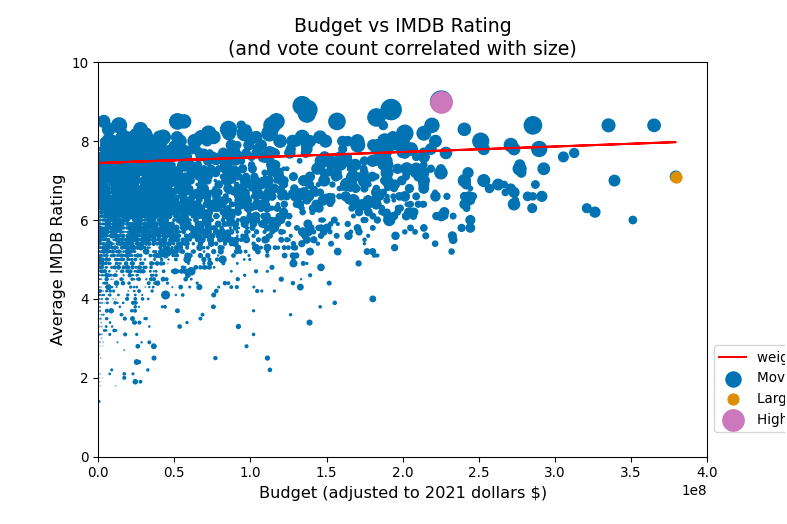

In [21]:
# BUDGET VS IMDB RATING PLOT
plt.figure(1)
plt.scatter(df.budget, df.weighted_average_vote, s = df.votes_scaled, color = color[0], label = "Movie, size correlated with count of votes")
plt.scatter(t_budget.budget, t_budget.weighted_average_vote, color = color[1], label = "Largest Budget: Pirates of the Caribbean - At World's End (585,229 votes)", s = t_budget.votes_scaled)
plt.scatter(t_votes.budget, t_votes.weighted_average_vote, color = color[4], label = "Highest Vote Count: The Dark Knight (2,241,615 votes)", s = t_votes.votes_scaled)
z = np.polyfit(x = df.budget, y = df.weighted_average_vote, w = df.votes_scaled, deg = 1) # LINEAR REGRESSION TRENDLINE WEIGHTED BY NUMBER OF VOTES
p = np.poly1d(z)
plt.plot(df.budget,p(df.budget),"-", color = "r", markersize = 10,label = f"weighted linear regression trendline, R-Value: {R1:.2f}")
plt.legend(bbox_to_anchor=(1, 0.30))
plt.xlabel('Budget (adjusted to 2021 dollars $)', size = 12)
plt.ylabel('Average IMDB Rating', size = 12)
plt.title(f'Budget vs IMDB Rating\n(and vote count correlated with size)', size = 14)
plt.axis([0, 400000000, 0, 10])
plt.show()

<IPython.core.display.Javascript object>


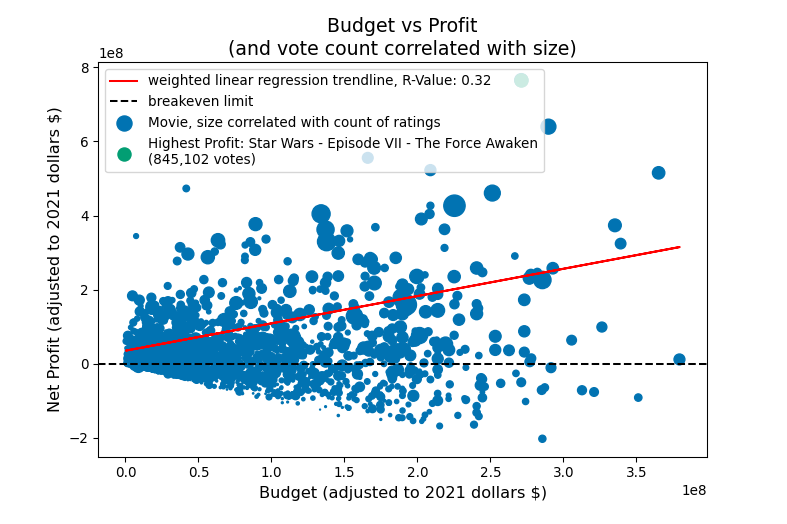

In [22]:
# BUDGET VS GROSS PROFIT PLOT
plt.figure(2)
plt.scatter(df.budget, df.profit, s = df.votes_scaled, color = color[0], label = "Movie, size correlated with count of ratings")
plt.scatter(t_profit.budget, t_profit.profit, color = color[2], label = f"Highest Profit: Star Wars - Episode VII - The Force Awaken\n(845,102 votes)", s = t_profit.votes_scaled)
z = np.polyfit(x = df.budget, y = df.profit, w = df.votes_scaled, deg = 1) # LINEAR REGRESSION TRENDLINE WEIGHTED BY NUMBER OF VOTES
p = np.poly1d(z)
plt.plot(df.budget,p(df.budget), "-", color = "r", markersize = 10,label = f"weighted linear regression trendline, R-Value: {R2:.2f}")
plt.axhline(y=1, color='black', linestyle='--', label = 'breakeven limit')
plt.legend()
plt.xlabel('Budget (adjusted to 2021 dollars $)',size = 12)
plt.ylabel('Net Profit (adjusted to 2021 dollars $)', size = 12)
plt.title(f'Budget vs Profit\n(and vote count correlated with size)', size = 14)
plt.show()

In [23]:
# CREATING A DATAFRAME TO PLOT AVERAGE ROI AND COUNT OF MOVIES BY IMDB RATING BIN
df['rounded_vote'] = df.weighted_average_vote.apply(np.floor) + 0.5
df_mean_2 = df.groupby('rounded_vote').mean()
df_mean_2['rounded_vote'] = df_mean_2.index
df_count_2 = df.groupby('rounded_vote').count()
df_count_2 = df_count_2.rename({'title': 'COUNT'}, axis=1)
df_mean_2 = df_mean_2.join(df_count_2.COUNT, how = 'left')

In [24]:
# UNDERSTANDING WHY 1 TO 2 RATING CATEGORY HAS HIGH ROI
df[df.rounded_vote == 1.5][['original_title', 'weighted_average_vote', 'budget', 'usa_gross_income', 'ratio']]

,original_title,weighted_average_vote,budget,usa_gross_income,ratio
3453,Exorcism,1.8,1.425491e+06,1.857415e+03,-99.869700
3483,Superbabies: Baby Geniuses 2,1.9,2.776645e+07,1.279948e+07,-53.903060
3898,Disaster Movie,1.9,2.435931e+07,1.728403e+07,-29.045495
5006,The Obama Effect,1.8,1.142151e+07,1.266692e+05,-98.890960
5436,Saving Christmas,1.4,5.538465e+05,3.083784e+06,456.794000
6521,Sex and the Future,1.9,1.013214e+06,3.141975e+03,-99.689900


<IPython.core.display.Javascript object>


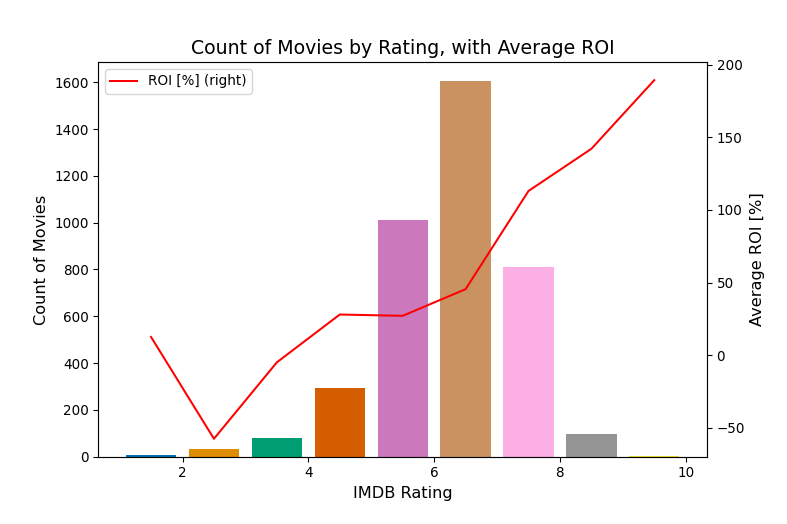

In [25]:
# PLOTTING RETURN ON INVESTMENT AND COUNT OF MOVIES BY IMDB RATING
fig, ax1 = plt.subplots()
plt.bar(df_mean_2.rounded_vote, df_mean_2.COUNT, label = 'count', color = color)
ax2 = df_mean_2.ratio.plot(secondary_y=True, color = 'r', label = 'ROI [%]')
plt.title(f'Count of Movies by Rating, with Average ROI', size = 14)
ax1.set_xlabel('IMDB Rating', size = 12)
ax1.set_ylabel('Count of Movies', size = 12)
ax2.set_ylabel('Average ROI [%]', size = 12)
plt.legend()
plt.show()

In [26]:
# CREATING A DATAFRAME TO PLOT AVERAGE ROI AND COUNT OF MOVIES BY IMDB RATING BINS
df = df.sort_values('budget')
bins =  np.arange(0, 400000000, 50000000)
df['bb'] = np.digitize(df['budget'], bins)
df.head(5)
df_mean_3 = df.groupby('bb').mean()
df_count_3 = df.groupby('bb').count()
df_count_3 = df_count_3.rename({'title': 'COUNT'}, axis=1)
df_mean_3 = df_mean_3.join(df_count_3.COUNT, how = 'left').round(1)
pd.set_option('display.float_format', '{:.2f}'.format)
df_mean_3[['budget', 'profit', 'ratio', 'weighted_average_vote', 'COUNT']]

,budget,profit,ratio,weighted_average_vote,COUNT
bb,,,,,
1,18255855.90,8257181.30,70.60,6.10,2736
2,71667385.00,11758130.30,16.40,6.20,644
3,121183921.50,11384727.90,8.80,6.30,280
4,175163146.30,26337512.50,15.10,6.70,170
5,220432413.10,56599165.60,26.60,6.80,73
6,274226041.00,129771497.90,47.50,7.10,25
7,323306991.90,119028058.00,35.30,7.20,6
8,365262563.10,145417970.40,39.50,7.20,3
